# Tarea 4 - LTE opacities for a pure H atmosphere

We try to reproduce Figure 8.5 a, b, c, d from Gray, which show the wavelength-dependent continuous absorption coefficient $\kappa_\lambda$ for different temperatures $T$ and electron pressures $P_e$.  For simplicity, we consider only hydrogen, in the form of the neutral atom and the positive and negative ions.  Ion fractions and excitation of bound levels is calculated under the assumption of local thermodynamic equilibrium. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='notebook', 
        style='whitegrid',
        palette='dark',
        font_scale=1.5,
        color_codes=True,
        rc={'figure.figsize': (8,6)},
       )

## Set up the constants we need

In [2]:
import astropy.units as u
from astropy.constants import k_B, h, m_p, a0, m_e
from astropy.constants import c as light_speed
from astropy.table import Table, Column

We work with all energies in electron volts. We define the constants as regular floats because it doesn't seem possible to use `astropy.units` quantities with `@np.vectorize`d functions.

In [3]:
BOLTZMANN = k_B.to(u.eV/u.K).value
PLANCK = h.to(u.eV*u.s).value
RYDBERG = (1.0*u.Ry).to(u.eV).value
HMINUS_EION = (0.754*u.eV).value
BOHR_RADIUS = a0.cgs.value

print('BOLTZMANN =', BOLTZMANN, 'eV/K')
print('PLANCK =', PLANCK, 'eV.s')
print('RYDBERG =', RYDBERG, 'eV')
print('HMINUS_EION =', HMINUS_EION, 'eV')
print('BOHR_RADIUS =', BOHR_RADIUS, 'cm')

BOLTZMANN = 8.617333262145179e-05 eV/K
PLANCK = 4.135667696923859e-15 eV.s
RYDBERG = 13.605693122994232 eV
HMINUS_EION = 0.754 eV
BOHR_RADIUS = 5.2917721090299995e-09 cm


## Ionization balance of hydrogen

### The general Saha equation

We use the following version of the Saha equation:
$$
\frac{N_{j+1} N_e}{N_j} = \Phi_j(T), 
$$
which relates the densities of adjacent ionization stages $j$ and $j+1$. 

First define the $T$-dependent function $\Phi_j = 4.8293744908\times 10^{15} \left(U_{j+1}/U_j\right) T^{1.5} e^{-E_j/k T}$, where $E_j$ is the $j$-th ionization potential and $U_j$, $U_{j+1}$ are the partition functions.

The temperature-dependent function on the RHS is
$$
\Phi_j(T) = 2 \left( \frac{2\pi m_e k T}{h^2} \right)^{1.5} \frac{U_{j+1}}{U_j} e^{-E_j/k T},
$$
where $E_j$ is the $j$-th ionization potential and $U_j$, $U_{j+1}$ are the partition functions.

We evaluate the constant

In [4]:
saha_C = 2*(2*np.pi*m_e*k_B / (h**2))**1.5
saha_C.cgs

<Quantity 4.82936608e+15 1 / (cm3 K(3/2))>

which is sometimes (e.g., Mihalas) given the other way up

In [5]:
1./saha_C.cgs

<Quantity 2.07066514e-16 cm3 K(3/2)>

and define a function to evaluate $\Phi_j(T;\, E_j, U_j, U_{j+1})$.  Default values of $U_j = 2$, $U_{j+1} = 1$ are correct for the H$^+$/H$^0$ balance at low temperatures.

In [6]:
SAHA_CONSTANT = saha_C.cgs.value

def Saha_Phi(T, Eion=1.0*RYDBERG, Ui=1.0, Un=2.0):
    """
    Función Phi(T) = (Ni Ne / Nn) de Saha 
    para energía de ionización Eion,
    y con funciones de partición Ui y Un
    """
    return SAHA_CONSTANT * (Ui/Un) * T**1.5 * np.exp(-Eion/(BOLTZMANN*T))




Test the function for some typical temperatures.  

In [7]:
Ts = np.array([3, 5, 9, 15])*u.kK
Ts.cgs

<Quantity [ 3000.,  5000.,  9000., 15000.] K>

Note that the `T` argument should be a normal number (e.g, `float`) in units of Kelvin.  In this example, we set up the temperature array in kilo-Kelvin, so we need to convert to cgs (or SI) and take the `value` before sending it to the function.  

In [8]:
Saha_Phi(Ts.cgs.value)

array([5.52056526e-03, 1.64960536e+07, 4.95873699e+13, 1.19037919e+17])

### The abundance of the positive hydrogen ion

We assume that the abundance of the negative ion H$^-$ is always a negligible of total H, so that we have equal numbers of protons and free electrons: $N_+ = N_e$. Then the H positive ionization fraction, $y = N_+ / N_H$, is the solution of the polynomial $y^2 + A y - A = 0$, where $A = \Phi_{H_0} / N_H$. 

We define a function `Hplus_fraction` that calculates $y$ as a function of total hydrogen density and temperature.  We use the `@np.vectorize` decorator so that we can apply the function to arrays of density and temperature. This is necessary here since `np.roots` solves only a single polynomial. 

In [9]:
@np.vectorize
def Hplus_fraction(Hden, T):
    """
    Calcular fracción de hidrógeno ionizado
   	
   	`Hden` es densidad de partículas totales de H en cm^{-3}
    `T` es temperatura en K
    """
    A = Saha_Phi(T) / Hden
    # Resolver polinomio: y**2 + A*y - A = 0
    y = np.roots([1.0, A, -A]).max() # tomar raiz positivo
    return y

For simplicity, we are here assuming that the H$^0$ partition function is equal to the statistical weight of the ground level: $g_1 = 2$.  This is a good approximation at lowish temperatures, where the population of excited levels is negligible.  We treat the more general case in the function `Hplus_fraction_U()` below. 

### The abundance of the negative hydrogen ion

The Saha equation for H⁻ is:
$$
\frac{N_{H^0} N_e}{N_{H^-}} = \Phi_{H^-}(T),
$$
from which it follows that 
$$
N_{H^-} \big/ N_H = \left( N_{H^0} \big/ N_H \right) N_e \big/ \Phi_{H^-} = (1 - y) y N_H \big/ \Phi_{H^-}
$$


In [10]:
def Hminus_fraction(Hden, T):
    """
    Calcular fracción del ión negativo de hidrógeno
    """ 
    y = Hplus_fraction(Hden, T)
    return y * (1. - y) * Hden/Saha_Phi(T, Eion=HMINUS_EION, Ui=2.0, Un=1.0)

### Table and graphs of the ion fractions

Define some typical atmospheric densities.  Then, make a table of the ion fractions four these four densities and the four temperatures that we defined above.

In [11]:
Ns = np.array([10, 3, 1, 0.5])*1e15/u.cm**3
Ns

<Quantity [1.e+16, 3.e+15, 1.e+15, 5.e+14] 1 / cm3>

In [14]:
fmt = "0.4e"
Table(
  data=[
    Column(Ns.cgs, name=r'$N_H$', format=fmt),
    Column(Ts.cgs, name=r'$T$', format=fmt),
    Column(Hplus_fraction(Ns.cgs.value, Ts.cgs.value), name=r'$N_+/N_H$', format=fmt),
    Column(Hminus_fraction(Ns.cgs.value, Ts.cgs.value), name=r'$N_-/N_H$', format=fmt),
  ])

$N_H$,$T$,$N_+/N_H$,$N_-/N_H$
1 / cm3,K,,
float64,float64,float64,float64
1.0000e+16,3.0000e+03,7.4301e-10,8.6508e-14
3.0000e+15,5.0000e+03,7.4150e-05,3.7482e-10
1.0000e+15,9.0000e+03,1.9926e-01,5.1151e-08
5.0000e+14,1.5000e+04,9.9583e-01,2.0946e-10


Note that the H⁻ fraction is always very small, which justifies ignoring its effect on the electron density. 

Next, we plot the ion fractions against temperature for a wide range of densities. 

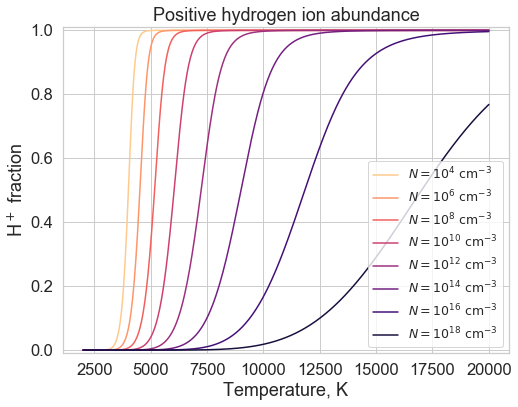

In [15]:
logNgrid = range(4, 20, 2)
Tgrid = np.linspace(2e3, 2e4, 500)
fig, ax = plt.subplots(1, 1)
legend_box_params = {
  'frameon': True,
  'fancybox': True,
  'fontsize': 'x-small',
}
colors = sns.color_palette('magma_r', n_colors=len(logNgrid))
epsilon = 0.01
for logN, c in zip(logNgrid, colors):
  ax.plot(Tgrid, Hplus_fraction(10**logN, Tgrid), color=c, 
          label=r'$N = 10^{{{}}}\ \mathrm{{cm}}^{{-3}}$'.format(logN))
frame = ax.legend(loc='lower right', **legend_box_params).get_frame()
frame.set_facecolor('white')
ax.set_ylim(-epsilon, 1 + epsilon)
ax.set_title('Positive hydrogen ion abundance')
ax.set_xlabel('Temperature, K')
ax.set_ylabel('H$^+$ fraction');

At the lower densities, hydrogen transitions from almost fully neutral to almost fully ionized over a narrow range of temperatures around 4000 K.  But such low densities are only seen in the corona, where LTE does not apply.   As the density is increased, higher temperatures are required and the curves shift to the right.  For densities characteristic of stellar photospheres, the transition occurs around 7000 to 10,000 K.

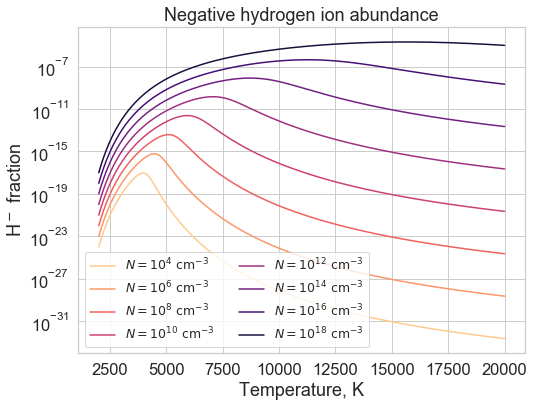

In [16]:
fig, ax = plt.subplots(1, 1)
for logN, c in zip(logNgrid, colors):
  ax.semilogy(Tgrid, Hminus_fraction(10**logN, Tgrid), color=c,
          label=r'$N = 10^{{{}}}\ \mathrm{{cm}}^{{-3}}$'.format(logN))
frame = ax.legend(loc='lower left', ncol=2, **legend_box_params).get_frame()
frame.set_facecolor('white')
ax.set_title('Negative hydrogen ion abundance')
ax.set_xlabel('Temperature, K')
ax.set_ylabel('H$^-$ fraction');

The abundance of negative hydrogen ion is shown on a logarithmic scale.  It generally increases with density, and it has a peak at the temperature where H is about 50% ionized, as can be seen by comparing this graph with the previous one.

## Excitation of bound levels of H⁰

We use the Boltzmann equation to calculate the fractional population of a given bound level, $n$, of neutral hydrogen.  
$$
\frac{N_n}{N_{H^0}} = \frac{g_n}{U(T)} e^{-E_n/k T}
$$
where the degeneracy is $g_n = 2 n^2$ and the energy in Rydbergs above the ground ($n=1$) level is $E_n = 1 - n^{-2}$.

Here is the function to do that:

In [39]:
def H0_level_population(n, T, U=2.0):
    """
    Calcular la población ETL del nivel n de hidrógeno neutro
    a una temperatura T kelvin
    """
    # Energía de excitación respeto a n=1
    E = RYDBERG * (1.0 - 1.0/n**2)
    # Peso estadístico
    g = 2.0*n**2
    return (g/U)*np.exp(-E/(BOLTZMANN*T))

**[Extra credit: not required for tarea]**

At low temperatures, the population of excited levels is negligible and we can take $U(T) \approx g_1 = 2$.  But, in general we need to evaluate the partition function as
$$
U(T) = \sum_1^{n_\mathrm{max}}\ g_n\ e^{-E_n/k T}
$$
We can calculate this by re-using the `H0_level_population` function:

In [40]:
@np.vectorize
def H0_partition_function(T, nmax):
  U = np.zeros_like(T)
  for n in range(1, int(nmax)+1):
    U += H0_level_population(n, T, U=1.0)
  return U

We cannot take $n_\mathrm{max} \to \infty$ in this func, since the sum diverges.  It is therefore important to find a physically motivated argument for determining the highest bound level, $n_\mathrm{max}$.

Taking account of the *pressure ionization* due to perturbations from neighboring particles, we make the approximation that in order that a level $n$ should be bound, the radius of the level, $r_n$, must be less than the average distance between particles: $\sim (N_H)^{-1/3}$.  Using $r_n = n^2 a_0$, where $a_0$ is the Bohr radius, this gives a maximum bound level $n_\mathrm{max} = a_0^{-1/2} N_H^{-1/6}$.  See Hubeny & Mihalas, Chapter 4, p. 91 for more details.


In [41]:
H0_partition_function(15000.0, 1000)

array(17918.86348415)

In [42]:
def nmax_pressure_ionization(Hden):
  """
  Calcular el nivel máximo ligado de H, sujeto a perturbaciones 
  por vecinos con densidad `Hden`
  """
  return 1./np.sqrt(BOHR_RADIUS*Hden**(1./3.))

Now we use the above function to make a table of $n_\mathrm{max}$ for different densities.  It is typicially $\sim 100$ for photospheric densities.  At the higher densities found in stellar interiors ($N_H > 10^{21}\ \mathrm{cm}^{-3}$) even the $n = 1$ level becomes unbound and H is fully ionized at all temperatures.

In [43]:
logNgrid_wide = range(4, 28, 2)
Ns = (10**np.array(logNgrid_wide, dtype='float'))*u.cm**-3
Table(data=[
  Column(Ns, 
        name=r'Hydrogen density, $N_H$', format='{:.0e}'),
  Column(nmax_pressure_ionization(Ns.value).astype(int), 
        name=r'Maximum bound level, $n_\mathrm{max}$')])

"Hydrogen density, $N_H$","Maximum bound level, $n_\mathrm{max}$"
1 / cm3,
float64,int64
1e+04,2961
1e+06,1374
1e+08,638
1e+10,296
1e+12,137
1e+14,63
1e+16,29
1e+18,13


Finally, we can return to the partition function, plotting it against $T$ using the $n_\mathrm{max}$ appropriate to different densities. For each density, the curves are only plotted for $T$ where the neutral hydrogen fraction, $1 - y$, is larger than $10^{-6}$.  We also show with symbols the points where the ionization fraction is $y = 0.95$ (squares) and $y = 0.999$ (circles).

In [44]:
np.zeros_like(0.0)

array(0.)

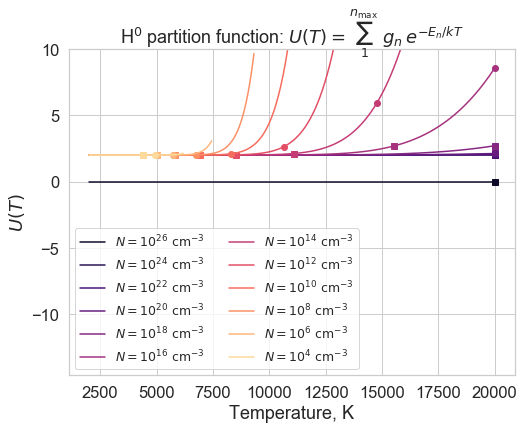

In [45]:
fig, ax = plt.subplots(1, 1)
colors = sns.color_palette('magma_r', n_colors=len(Ns))
for Hden, c in zip(Ns.value[::-1], colors[::-1]):
  nmax = int(nmax_pressure_ionization(Hden))
  Ugrid = H0_partition_function(Tgrid, nmax=nmax)
  mask = 1.0 - Hplus_fraction(Hden, Tgrid) > 1.e-6
  ax.plot(Tgrid[mask], Ugrid[mask], color=c,
         label=r'$N = 10^{{{}}}\ \mathrm{{cm}}^{{-3}}$'.format(int(np.log10(Hden))))
  for y, sym in [0.95, 's'], [0.999, 'o']:
    i0 = np.argmin(np.abs(Hplus_fraction(Hden, Tgrid) - y)) 
    ax.plot(Tgrid[i0], Ugrid[i0], sym, color=c)
ax.set_ylim(None, 10.)
frame = ax.legend(loc='lower left', ncol=2, **legend_box_params).get_frame()
frame.set_facecolor('white')
sigmatext = r'$U(T) = \sum_1^{n_\mathrm{max}}\ g_n\, e^{-E_n/k T}$'
ax.set_title('H$^0$ partition function: ' + sigmatext)
ax.set_xlabel('Temperature, K')
ax.set_ylabel(r'$U(T)$');        

It can be seen that $U(T)$ only rises noticeably above $2$ for densities above $10^8\ \mathrm{cm}^{-3}$, and that it only becomes large when the hydrogen is nearly completely ionized ($y \gtrapprox 0.999$).  For the highest density of $10^{26}\ \mathrm{cm}^{-3}$, we have $n_\mathrm{max} = 0$, which means that there are no bound states at all, so $U(T) = 0$.

In the function `Hplus_fraction` above, we calculated the hydrogen ionization fraction under the approximation that $U(T) = 2$.  We will now redo this function, but using the better approximation to $U(T)$ that we have just found.

For consistency, we should also incorporate the *continuum lowering* effect in the ionization balance.  It can be included in a simple way by reducing the H⁰ ionization potential. However, once the ground level becomes unbound, then the approximations that we are using are no longer valid, so we should not expect this to be accurate for very large densities. 

In [46]:
@np.vectorize
def Hplus_fraction_U(Hden, T):
    """
    Calcular fracción de hidrógeno ionizado con un U(T) más realista
   	
   	`Hden` es densidad de partículas totales de H en cm^{-3}
    `T` es temperatura en K
    """
    nmax = nmax_pressure_ionization(Hden)
    if nmax < 1.0:
        # pressure ionization
        y = 1.0
    else:
        U = H0_partition_function(T, nmax=int(nmax))
        Ei = RYDBERG*(1.0 - 1.0/nmax**2)
        A = Saha_Phi(T, Eion=Ei, Un=U) / Hden
        # Resolver polinomio: y**2 + A*y - A = 0
        y = np.roots([1.0, A, -A])[1] # tomar raiz positivo
    return y

Now we compare the two approximations.  The constant-$U$ version is shown as a dashed line and the new version as a solid line.  We change to a logarithmic scale in temperature so we can see the effects of very large densities more clearly.

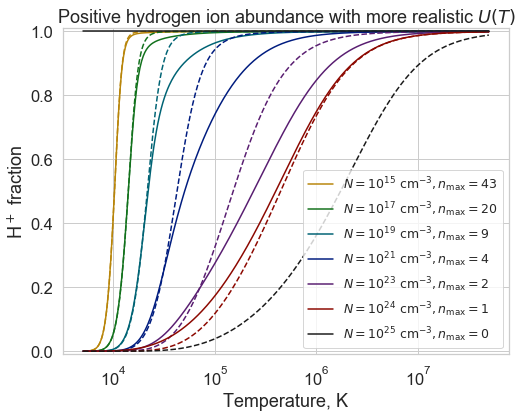

In [47]:
Tgrid_wide = np.logspace(3.7, 7.7, 500)
logNgrid_wide = list(range(15, 25, 2)) + [24, 25]
#colors_wide = sns.color_palette('magma_r', n_colors=len(logNgrid_wide))
colors_wide = 'ygcbmrk'
fig, ax = plt.subplots(1, 1)
for logN, c in zip(logNgrid_wide, colors_wide):
  Hden = 10**logN
  nmax = int(nmax_pressure_ionization(Hden))
  ax.plot(Tgrid_wide, Hplus_fraction_U(Hden, Tgrid_wide), color=c, 
          label=rf'$N = 10^{{{logN}}}\ \mathrm{{cm}}^{{-3}}, n_\mathrm{{max}} = {nmax}$')
  ax.plot(Tgrid_wide, Hplus_fraction(Hden, Tgrid_wide), '--', color=c, 
          label=None)
frame = ax.legend(loc='lower right', **legend_box_params).get_frame()
frame.set_facecolor('white')
ax.set_ylim(-epsilon, 1 + epsilon)
ax.set_xscale('log')
ax.set_title('Positive hydrogen ion abundance with more realistic $U(T)$')
ax.set_xlabel('Temperature, K')
ax.set_ylabel('H$^+$ fraction');

At densities ${}\le 10^{15}\ \mathrm{cm}^{-3}$, there is almost no effect at all. At moderate densities of $10^{17}$ to $10^{21}\ \mathrm{cm}^{-3}$ the prinicipal effect is to increase the neutral fraction at temperatures where H is nearly fully ionized.  This is due to $U$ increasing, which favors the neutral atom.  But, for the very highest densities $\gt 10^{21}\ \mathrm{cm}^{-3}$, the continuum lowering starts to dominate and the partial ionization extends to lower temperatures due to reduction in the ionization potential.  This also tends to reduce $U$ again, since there *are* no excited levels to populate. Finally, for $N > 10^{24}\ \mathrm{cm}^{-3}$, even the ground level is unbound, so ionization is complete at all temperatures.

## Wavelength-dependent cross sections

### Neutral hydrogen H⁰

#### Bound-free photoionization cross sections

For photoionization from level $n$, there is a threshold energy, $E_n = n^{-2}\ \mathrm{Ry}$, with a corresponding minimum frequency, $\nu_n = E_n/h$, or maximum wavelength, $\lambda_n = h c / E_n$.  The cross section is given by
$$
\sigma_\mathrm{bf}(n, \nu) = \sigma_0 n \frac{\nu_n^3}{\nu^3} g_\mathrm{bf}(n, \nu)
$$
where $\sigma_0 = 2.815\times 10^{29} \nu_1^{-3} =  7.906 \times 10^{-18}\ \mathrm{cm}^2$ and $g_\mathrm{bf}(n, \nu)$ is the Gaunt factor that corrects for quantum mechanical effects.  

In [21]:
@np.vectorize
def xsec_H0_boundfree(n, nu, xsec0=7.906e-18):
    """
    Sección eficaz de fotoionización de nivel n de H0 a frecuencia nu Hz

    Multiplicar por densidad de H0(n) para dar coeficiente de absorción (cm^{-1})
    """
    E = PLANCK*nu               # energía de fotón
    E0 = RYDBERG/n**2           # energía de ionización de nivel n

    if E >= E0:
        xsec = gaunt_H0_boundfree(n, nu)*xsec0*n*(E0/E)**3
    else:
        xsec = 0.0

    return xsec

For the gaunt factor we use the Menzel & Perkis approximation given in Gray's Eq (8.5):
$$
g_\mathrm{bf}(n, \nu) = 1 - \frac{0.3456}{(\lambda R)^{1/3}} 
\left( \frac{\lambda R}{n^2} - \frac{1}{2}\right) .
$$

In [22]:
def gaunt_H0_boundfree(n, nu):
  """
  Factor Gaunt para fotoionización de nivel `n` de H0 a frecuencia `nu` Hz
  """
  lambda_R = RYDBERG/(PLANCK*nu)
  return 1.0 - 0.3456*(lambda_R/n**2 - 0.5)/lambda_R**(1./3.)

Define an array of wavelengths for plotting and calculate the corresponding frequencies. 

In [23]:
wavs = np.linspace(40.0, 20000.0, 500)*u.AA
freqs = (light_speed/wavs).cgs
freqs[[0, -1]]

<Quantity [7.49481145e+16, 1.49896229e+14] 1 / s>

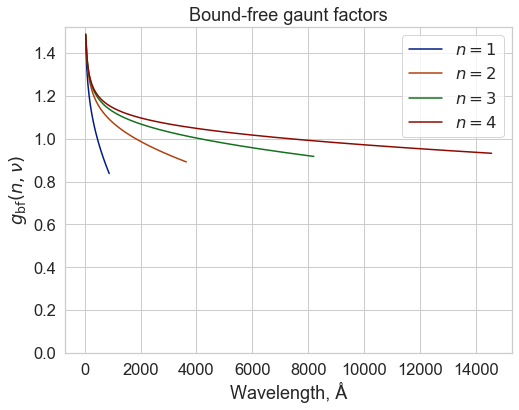

In [24]:
fig, ax = plt.subplots(1, 1)
for n in range(1, 5):
  m = h*freqs >= 1.0*u.Ry/n**2
  ax.plot(wavs[m], gaunt_H0_boundfree(n, freqs.value[m]), 
         label=r'$n = {}$'.format(n))
ax.set_ylim(0.0, None)
ax.legend()
ax.set_xlabel(r'Wavelength, Å')
ax.set_ylabel(r'$g_\mathrm{bf}(n, \nu)$')
ax.set_title('Bound-free gaunt factors');

The gaunt factors are of order unity, tending to increase slightly in the ultraviolet.  For each $n$, it only makes sense to plot them for $\lambda < \lambda_n$. 

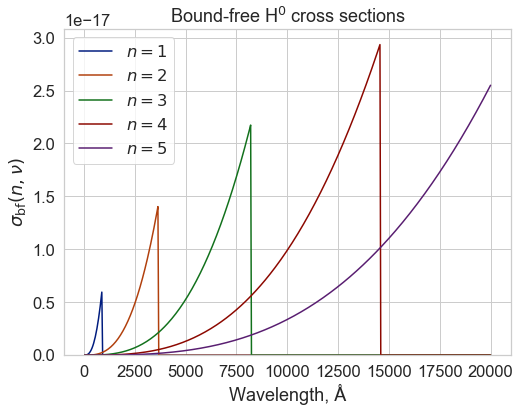

In [25]:
fig, ax = plt.subplots(1, 1)
for n in range(1, 6):
  ax.plot(wavs, xsec_H0_boundfree(n, freqs.value), 
         label=r'$n = {}$'.format(n))
ax.set_ylim(0.0, None)
ax.legend(loc='upper left')
ax.set_xlabel(r'Wavelength, Å')
ax.set_ylabel(r'$\sigma_\mathrm{bf}(n, \nu)$')
ax.set_title('Bound-free H$^0$ cross sections');

The cross sections can be compared with Gray's Fig 8.2.

### Free-free H⁰ cross-sections


The cross section per electron (see Rybicki, section 5.3) can be written as 
$$
\alpha_\mathrm{ff} = \alpha_0 \frac{g_\mathrm{ff}(T, \nu)}{\nu^3 T^{1/2}} \quad \mathrm{cm^2\ \big/\ e^-}, 
$$
where 
$$
\alpha_0 = \frac{4 e^6}{3 m h c} \left(\frac{2\pi}{3 k m}\right)^{1/2} , 
$$
and the free-free Gaunt factor can be approximated (Gray, Eq. 8.6) as 
$$
g_\mathrm{ff}(T, \nu) = 1 - \frac{0.3456}{(\lambda R)^{1/3}} 
\left( \frac{k T}{h \nu} + \frac{1}{2}\right) .
$$
We calculate the numerical value of the constant, $\alpha_0$:

In [17]:
from astropy.constants import e, m_e
alpha0 = np.sqrt(2*np.pi/(3*k_B*m_e))*(4*e.esu**6)/(3*m_e*h*light_speed)
alpha0.cgs

<Quantity 3.69234911e+08 cm5 K(1/2) / s3>

In [28]:
def xsec_H0_freefree(T, nu):
    """
    Sección eficaz por electrón de bremsstrahlung a frecuencia nu Hz

    Multiplicar por Ne N(H+) para dar coeficiente de absorción (cm^{-1})
    """
    # cf. Rybicki, eq. 5.18b, but we omit the (1 - exp(-h nu/k T)) term
    # since we will apply it later
    return alpha0.cgs.value * gaunt_H0_freefree(T, nu) * T**-0.5 / nu**3

In [19]:
def gaunt_H0_freefree(T, nu):
  """
  Factor Gaunt para absorción libre-libre H0 a frecuencia `nu` Hz
  """
  lambda_R = RYDBERG/(PLANCK*nu)
  return 1.0 - 0.3456*(BOLTZMANN*T/(PLANCK*nu) + 0.5)/lambda_R**(1./3.)

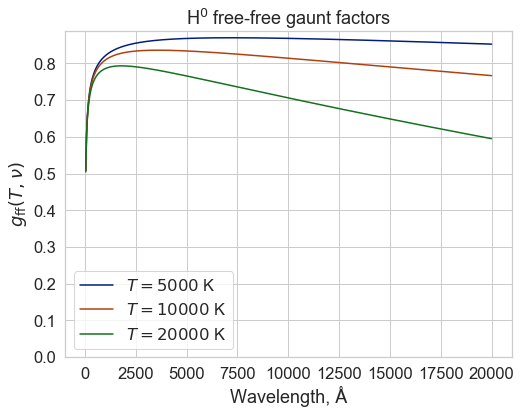

In [26]:
fig, ax = plt.subplots(1, 1)
for T in [5e3, 1e4, 2e4]:
  ax.plot(wavs, gaunt_H0_freefree(T, freqs.value), 
         label=r'$T = {:.0f}$ K'.format(T))
ax.set_ylim(0.0, None)
ax.legend(loc='lower left')
ax.set_xlabel(r'Wavelength, Å')
ax.set_ylabel(r'$g_\mathrm{ff}(T, \nu)$')
ax.set_title('H$^0$ free-free gaunt factors');

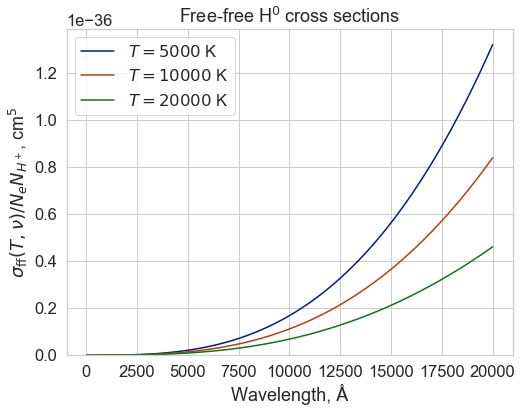

In [29]:
fig, ax = plt.subplots(1, 1)
for T in [5e3, 1e4, 2e4]:
  ax.plot(wavs, xsec_H0_freefree(T, freqs.value), 
         label=r'$T = {:.0f}$ K'.format(T))
ax.set_ylim(0.0, None)
ax.legend(loc='upper left')
ax.set_xlabel(r'Wavelength, Å')
ax.set_ylabel(r'$\sigma_\mathrm{ff}(T, \nu) / N_e N_{H^+}$, cm$^5$')
ax.set_title('Free-free H$^0$ cross sections');

### Negative hydrogen ion H⁻

#### Bound-free H⁻ cross section

We use the polynomial fit from Gray, which is stated to be accurate in the range $2250~Å < \lambda < 15,000~Å.$  This gives the cross section in $\mathrm{cm}^2$, so it needs to be multiplied by $N_{H^-}$. 

In [30]:
@np.vectorize
def xsec_Hminus_boundfree(nu):
    """
    Sección eficaz de fotoionización del ión negativo H- a frecuencia nu Hz

    Multiplicar por N(H-) para dar coeficiente de absorción (cm^{-1})
    """
    # convertir nu a lambda en unidades de micras (10,000 Å)
    wav = (light_speed / (nu * u.Hz)).to(u.micron).value  
    # Fórmula y constantes de Gray, Eq. 8.11
    A = [1.99654, -1.18267e-1, 2.64243e2, 
         -4.40524e2, 3.23992e2, -1.39568e2, 2.78701e1]
    xsec = 0.0
    # El ajuste es preciso para 2250 Å <= lambda <= 15,000 Å 
    # Hay que cortarlo a partir de 16,200 Å porque el ajuste va negativo
    for i, a in enumerate(A):
        if wav <= 1.62:
            xsec += a*wav**i
    return xsec * 1.e-18

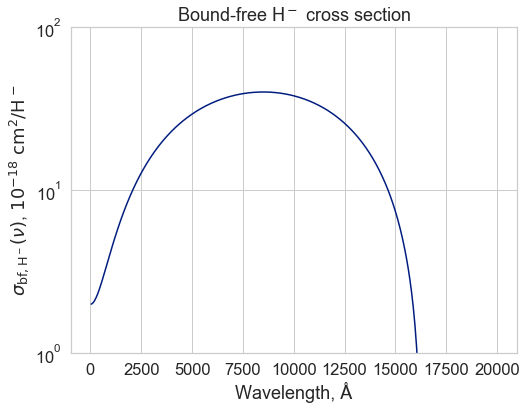

In [31]:
fig, ax = plt.subplots(1, 1)
ax.plot(wavs, xsec_Hminus_boundfree(freqs.value)/1e-18, 
         label=r'bf')
ax.set_ylim(0.0, 5e-17)
#ax.legend(loc='lower center')
ax.set_yscale('log')
ax.set_ylim(1.0, 100.0)
ax.set_xlabel(r'Wavelength, Å')
ax.set_ylabel(r'$\sigma_\mathrm{bf,H^-}(\nu)$, $10^{-18}\ \mathrm{cm}^2 / \mathrm{H}^-$')
ax.set_title('Bound-free H$^-$ cross section');

The graph above bears a reasonable resemblance to Gray's Fig. 8.3

#### Free-free H⁻ opacity

This is also calculated from polynomial fits given by Gray, which accurately reproduce the results of Bell & Berrington (1987) for the range $1823~Å < \lambda < 151,890~Å$ and $1400~\mathrm{K} < T < 10,080~\mathrm{K}$.

In [32]:
def Hz_to_AA(nu):
  """
  Utility function to translate frequency to wavelength
  """
  return (light_speed / (nu / u.s)).to(u.AA).value

@np.vectorize
def xsec_Hminus_freefree(T, nu):
    """
    Opacidad libre-libre del ión negativo H- a frecuencia nu Hz

    Multiplicar por Pe N(H0) para dar coeficiente de absorción (cm^{-1})
    + Ojo que no hay que multiplicar por N(H-)
    + Y esto ya incluye la correción por emisión estimulada
    """
    # convertir nu a lambda en unidades de Å
    wav = Hz_to_AA(nu)  
    logwav = np.log10(wav)
    # Eq. 8.13 de Gray
    f0 = -2.2763 - 1.6850*logwav + 0.76661*logwav**2 - 0.053346*logwav**3
    f1 = 15.2827 - 9.2846*logwav + 1.99381*logwav**2 - 0.142631*logwav**3
    f2 = (-197.789 + 190.266*logwav 
          - 67.9775*logwav**2 + 10.6913*logwav**3 - 0.625151*logwav**4)
    theta = np.log10(np.e) / (BOLTZMANN*T) # aproximadamente theta = 5040/T
    xsec = 1.e-26 * 10**(f0 + f1*np.log10(theta) + f2*np.log10(theta)**2)
    return xsec

The free free opacity is more important at longer wavelengths, so we define an extended range of wavelengths for plotting, up to just over $10~µm$. 

In [33]:
wavs_extend = np.logspace(3.1, 5.1, 500)*u.AA
freqs_extend = (light_speed/wavs_extend).cgs

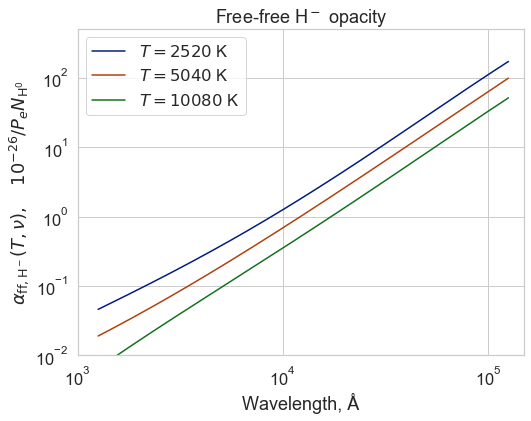

In [34]:
fig, ax = plt.subplots(1, 1)
for T in [2520.0, 5040.0, 10080.0]:
  ax.plot(wavs_extend, xsec_Hminus_freefree(T, freqs_extend.value)/1e-26, 
         label=r'$T = {:.0f}$ K'.format(T))
ax.plot()
ax.set_ylim(0.01, 500)
ax.set_xlim(1000.0, 150000.0)
ax.legend(loc='upper left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength, Å')
ax.set_ylabel(r'$\alpha_\mathrm{ff,H^-}(T, \nu),\quad 10^{-26}/ P_e N_\mathrm{H^0}$ ')
ax.set_title('Free-free H$^-$ opacity');

This graph closely resemble Gray's Fig. 8.4.  Note that the fits already include the correction for stimulated emission and are per neutral H atom and per unit electron pressure.

## Finding the total hydrogen density in terms of electron pressure

The graphs we are trying to reproduce are for fixed values of $T$ and $P_e$, but most of our equations are in terms of densities, so need functions to convert between the two.  Going from hydrogen density to electron pressure is straightforward:

In [35]:
def funcPe(Hden, T):
    """
    Presión electrónica como función de densidad total y temperatura
    """
    return Hden*Hplus_fraction_U(Hden, T)*k_B.cgs.value*T

In [50]:
def funcPe_simple(Hden, T):
    """
    Presión electrónica como función de densidad total y temperatura
    """
    return Hden*Hplus_fraction(Hden, T)*k_B.cgs.value*T

At high temperatures, ionization is complete and $P_e$ increases linearly with $T$, which looks quite flat on the following graph because of the logarithmic scale on the $y$ axis. At lower temperatures the ionization fraction falls, and so $P_e$ drops steeply.

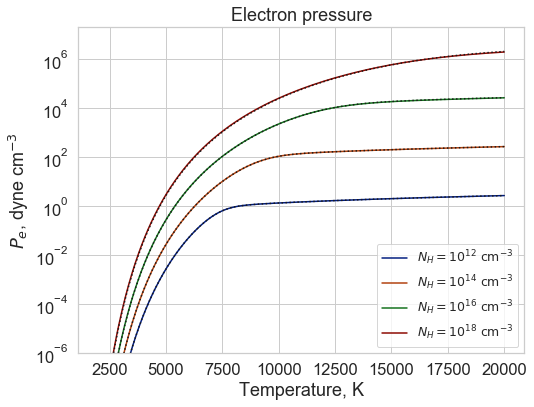

In [53]:
fig, ax = plt.subplots(1, 1)
for Hden in [1e12, 1e14, 1e16, 1e18]:
  ax.plot(Tgrid, funcPe(Hden, Tgrid), 
          label=r'$N_H = 10^{{{:.0f}}}\ \mathrm{{cm^{{-3}}}}$'.format(np.log10(Hden)))
  ax.plot(Tgrid, funcPe_simple(Hden, Tgrid), ls=":", c="k",
          label="_nolabel_")
frame = ax.legend(loc='lower right', **legend_box_params).get_frame()
frame.set_facecolor('white')
ax.set_yscale('log')
ax.set_ylim(1e-6, None)
ax.set_title('Electron pressure')
ax.set_xlabel('Temperature, K')
ax.set_ylabel('$P_e$, dyne cm$^{-3}$');

Going in the other direction requires solving an implicit equation:

In [54]:
@np.vectorize
def funcHden(Pe, T):
    """
    Densidad total como función de Pe y T

    Esta función busca numericamente el raiz para Hden de la función

    funcPe(Hden, T) - Pe = 0

    empezando con un primer intento que suponga 50% ionización
    """
    from scipy.optimize import fsolve
    Hden0 = 0.5*Pe / (k_B.cgs.value*T) # primer intento es 50% ionizado
    return fsolve(lambda Hden: funcPe(Hden, T) - Pe, Hden0)[0]

We now test this function by making a graph of total hydrogen density for electron pressures $P_e = 1 \to 1000\ \mathrm{dyne\ cm^2}$ and temperatures $T = 4500 \to 20,000\ \mathrm{K}$. We can't go to much lower temperatures because the electron fraction becomes so low that it is impossible to find a reasonable solution for the higher values of $P_e$.

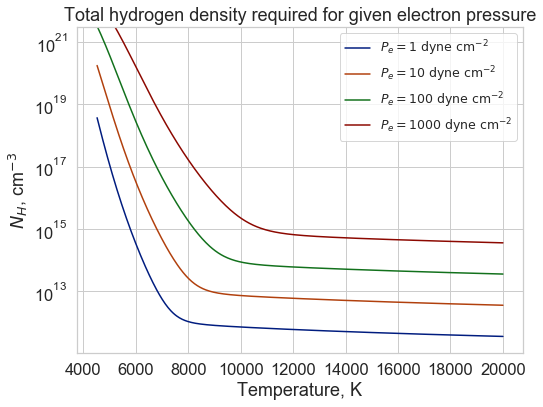

In [55]:
fig, ax = plt.subplots(1, 1)
for Pe in [1.0, 10., 100., 1000.]:
  m = Tgrid >= 4500.0
  ax.plot(Tgrid[m], funcHden(Pe, Tgrid[m]), 
          label=r'$P_e = {:.0f}\ \mathrm{{dyne\ cm^{{-2}}}}$'.format(Pe))
frame = ax.legend(loc='upper right', **legend_box_params).get_frame()
frame.set_facecolor('white')
ax.set_yscale('log')
ax.set_ylim(None, 3e21)
ax.set_title('Total hydrogen density required for given electron pressure')
ax.set_xlabel('Temperature, K')
ax.set_ylabel('$N_{H}$, cm$^{-3}$');

## Total wavelength-dependent opacities


In [56]:
def opacidad_total(Pe, T, wavs):
    """
    Calcular la opacidad total del continuo de un gas de H puro en ETL

    Parámetros de entrada:
    
    Pe   : presión de electrones (dyne cm^{-2})
    T    : temperatura (K)
    wavs : longitud de onda (Å)

    Resultado: 

    opacities: dict con coeficiente de absorción por masa (cm^2/g)
               elementos son "Total", "H0bf", "H0ff", "Hmbf", "Hmff"
    """

    Hden = funcHden(Pe, T)                # densidad total de H
    y = Hplus_fraction_U(Hden, T)           # fracción de ionización
    Hpden = y*Hden                        # densidad de H+
    eden = y*Hden                         # densidad de electrones
    H0den = (1.0 - y)*Hden                # densidad de H0
    Hmden = Hden*Hminus_fraction(Hden, T) # densidad de H-

    # frequencies are pure numbers in Hz
    nu = (light_speed/(wavs*u.AA)).cgs.value
    stimulated_correction = (1.0 - np.exp(-h.cgs.value*nu / (k_B.cgs.value*T)))
    opacities = {}
    
    # H0 ligado-libre
    opacities["H0bf"] = 0.0
    nmax = int(nmax_pressure_ionization(Hden))
    Un = H0_partition_function(T, nmax)
    for n in range(1, nmax+1):
        opacities["H0bf"] += H0den * H0_level_population(n, T, Un) * xsec_H0_boundfree(n, nu)
    opacities["H0bf"] *= stimulated_correction
    # H0 libre-libre
    opacities["H0ff"] = Hpden * eden * xsec_H0_freefree(T, nu)
    opacities["H0ff"] *= stimulated_correction
    # H- ligado-libre
    opacities["Hmbf"] = Hmden * xsec_Hminus_boundfree(nu)
    opacities["Hmbf"] *= stimulated_correction 
    # H- libre-libre (que ya incluye emisión estimulada)
    opacities["Hmff"] = H0den * Pe * xsec_Hminus_freefree(T, nu)
    
    # convertir a opacidad por masa
    total = 0.0
    for k in opacities.keys():
      m = opacities[k] < 0.0
      opacities[k][m] = 0.0
      opacities[k] /= H0den*m_p.cgs.value
      total += opacities[k]
    opacities["Total"] = total
    # guardar metadata
    opacities["metadata"] = {'N_H': Hden, 'y_H': y}

    return opacities

In [71]:
opacidad_total(Pe=3000.0, T=1e4, wavs=[3000, 10000])

TypeError: only size-1 arrays can be converted to Python scalars

### Reproducing Gray's Fig 8.5

In [58]:
styles = {
  'Total': {'color': 'k', 'ls': '-'},
  'H0bf': {'color': 'r', 'ls': '-'},
  'H0ff': {'color': 'r', 'ls': '--'},
  'Hmbf': {'color': 'g', 'ls': '-'},
  'Hmff': {'color': 'g', 'ls': '--'},
}
def plot_opacities(Pe, T, wavrange=[3000., 20000.], yscale='linear'):
  wavs = np.linspace(wavrange[0], wavrange[1], 500)
  fig, ax = plt.subplots(1, 1)
  opac = opacidad_total(Pe, T, wavs)
  data = opac.pop('metadata')
  for kwd in opac.keys():
    ax.plot(wavs, opac[kwd]*m_p.cgs.value/Pe/1e-26, label=kwd, **styles[kwd])
  frame = ax.legend(loc='upper right', **legend_box_params).get_frame()
  frame.set_facecolor('white')
  strings = []
  strings.append('$T = {}$ K'.format(T))
  strings.append(r'$\log_{{10}} P_e = {:.2f}$'.format(np.log10(Pe)))
  strings.append(r'$\log_{{10}} N_H = {:.2f}$'.format(np.log10(float(data['N_H']))))
  strings.append('$y = {:.5f}$'.format(float(data['y_H'])))
  ax.set_title(r'$\quad$'.join(strings), fontsize='small')
  ax.set_xlabel('Wavelength, Å')
  ax.set_ylabel('Opacity per H per unit electron pressure / $10^{-26}$')
  ax.set_yscale(yscale)
  return None

#### Fig 8.5 (a) — 5143 K

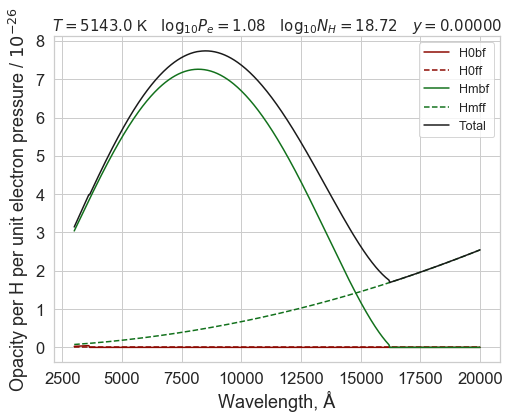

In [59]:
plot_opacities(10**1.08, 5143.0)

Lowest temperature. Dominated by H$^-$ opacity.  _Why does Gray not get such a high free-free opacity as we do?_

#### Fig 8.5 (b) — 6429 K

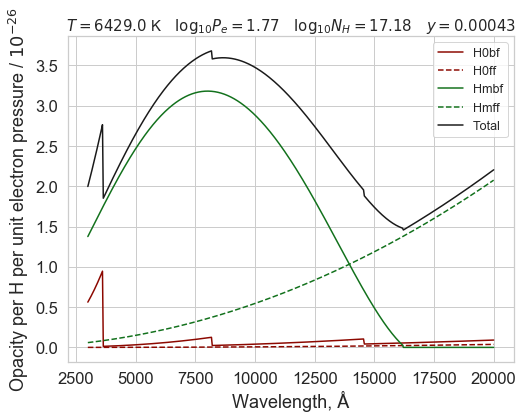

In [60]:
plot_opacities(10**1.77, 6429.0)

Start to see the H$^0$ absorption edges superimposed on the H$^-$.  Of the four graphs, this is the one that looks most like Gray's version.

#### Fig 8.5 (c) — 7715 K

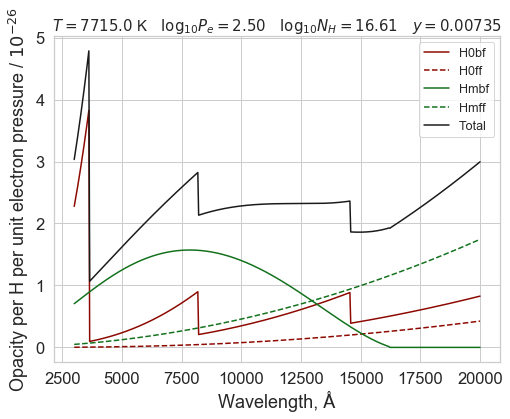

In [61]:
plot_opacities(10**2.50, 7715.0)

H$^0$ and H$^-$ are of roughly equal importance at this temperature.

#### Fig 8.5 (d) — 11,572 K

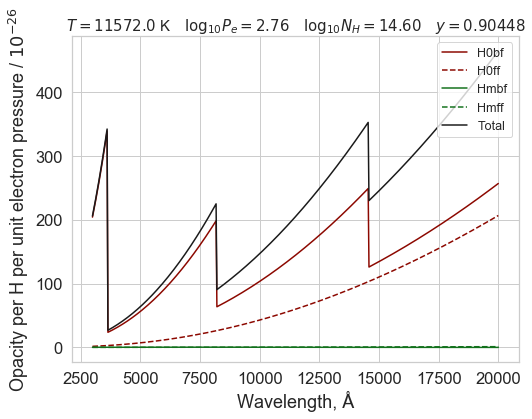

In [62]:
plot_opacities(10**2.76, 11572.0)

H$^0$ opacity now completely dominates. _My excited levels are not as high as in Gray's graph, – why?_ 

Note that in the 2016 version, my general magnitude was 20 times lower.  But that is because I was normalizing by the total H density, whereas Gray is using (strangely) the neutral atomic hytrogen density.  This only matters for panel (d), since it is the only case where H is appreciably ionized.

#### A much higher temperature and density

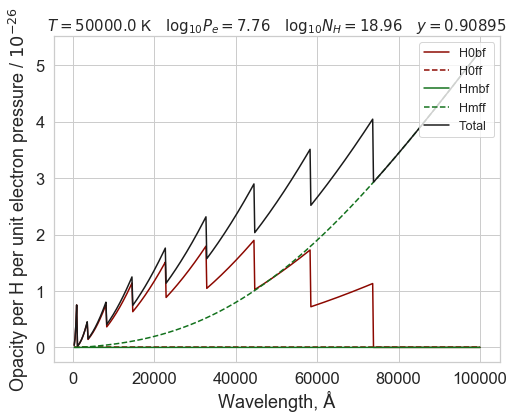

In [50]:
plot_opacities(10**7.76, 50000.0, wavrange=[300, 100000])

Now we see the pressure-ionization of the upper levels (only $n \le 8$ are populated). 

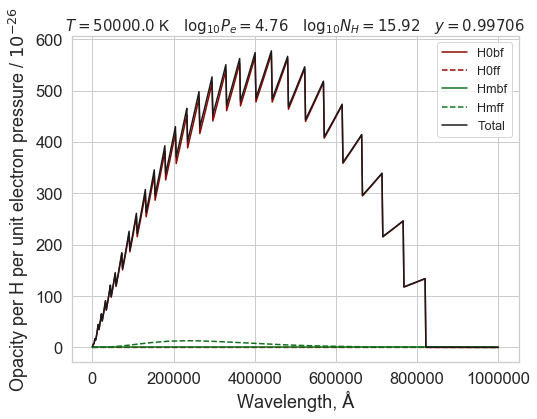

In [51]:
plot_opacities(10**4.76, 50000.0, wavrange=[300, 1e6])

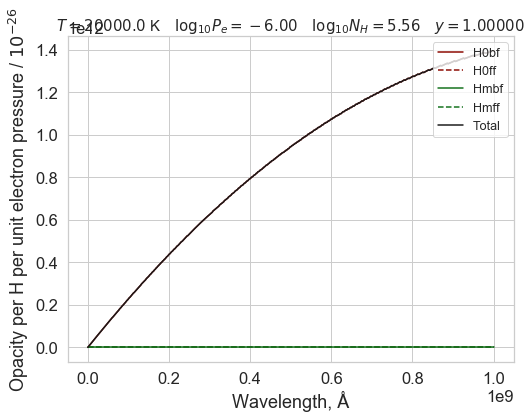

In [52]:
plot_opacities(1e-6, 20000.0, wavrange=[300, 1e9])

## Check against Cloudy results

In [53]:
from astropy.table import Table

In [54]:
Table.read?

In [55]:
fn = "cloudy/lte_opacity_6429.opac"
tc = Table.read(fn, format='ascii.tab', names=['nu', 'tot', 'abs', 'scat', 'albedo', 'elem'])

In [56]:
tc['wav'] = 912.0/tc['nu']
wavmin, wavmax = 2500, 20000
m = (tc['wav'] >= wavmin) & (tc['wav'] <= wavmax)
tc[m]

nu,tot,abs,scat,albedo,elem,wav
float64,float64,float64,float64,float64,str4,float64
0.045731,1.05e-07,1.05e-07,3.09e-11,0.000295,,19942.708447223984
0.045884,1.04e-07,1.04e-07,3.09e-11,0.000297,,19876.209571964082
0.046037,1.03e-07,1.03e-07,3.09e-11,0.000299,,19810.15270326042
0.04619,1.03e-07,1.03e-07,3.09e-11,0.000301,,19744.53344879844
0.046345,1.02e-07,1.02e-07,3.09e-11,0.000303,,19678.498219872694
0.046499,1.01e-07,1.01e-07,3.09e-11,0.000305,,19613.325017742318
0.046655,1.01e-07,1e-07,3.09e-11,0.000307,,19547.74407887686
0.04681,9.98e-08,9.98e-08,3.09e-11,0.00031,,19483.01644947661
0.046967,9.91e-08,9.91e-08,3.09e-11,0.000312,,19417.889156216064


[(0.0, 1.09585e-07), (2500, 20000)]

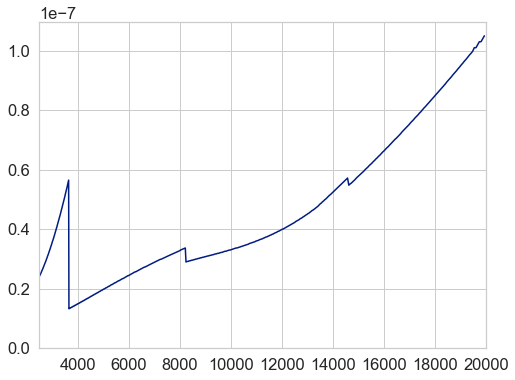

In [57]:
fig, ax = plt.subplots()
ax.plot(tc[m]['wav'], tc[m]['tot'])
ax.set(xlim=[wavmin, wavmax], ylim=[0.0, None])

### First concentrate on ionization fractions and level populations

I have run some grid models based on the Cloudy test script `limit_lte_hminus.in`, in which I vary the density.


In [58]:
fn = "cloudy/limit_lte_hminus_density_grid.hcond"
thc = Table.read(fn, format='ascii.commented_header', delimiter='\t')
thl = Table.read(fn.replace('hminus', 'hminus_large'), format='ascii.commented_header', delimiter='\t')
thf = Table.read(fn.replace('limit', 'force'), format='ascii.commented_header', delimiter='\t')

The `thc` table is from model where we let Cloudy find the equilibrium on its own

In [59]:
thc[::4]

depth,Te,HDEN,EDEN,HI/H,HII/H,H2/H,H2+/H,H3+/H,H-/H
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.5,5000.0,100000000.0,33600000.0,0.664,0.336,2.58e-13,4.64e-14,1.08e-20,3.74e-14
0.5,5000.0,10000000000.0,404000000.0,0.96,0.0404,3.06e-11,8.07e-13,2.11e-18,6.5e-13
0.5,5000.0,1000000000000.0,4170000000.0,0.996,0.00417,3.1e-09,8.53e-12,1.55e-16,6.96e-12
0.5,5000.0,100000000000000.0,37000000000.0,1.0,0.00037,1.32e-07,3.38e-11,1.61e-15,5.99e-11
0.5,5000.0,1e+16,205000000000.0,1.0,2.05e-05,3.55e-06,3.66e-12,6.74e-16,4.34e-11


While the `thf` table is from model where we try to force LTE.

In [60]:
thf[::4]

depth,Te,HDEN,EDEN,HI/H,HII/H,H2/H,H2+/H,H3+/H,H-/H
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.5,5000.0,100000000.0,33400000.0,0.666,0.334,2.56e-13,4.63e-14,1.08e-20,3.73e-14
0.5,5000.0,10000000000.0,401000000.0,0.96,0.0401,3.05e-11,8.02e-13,2.11e-18,6.46e-13
0.5,5000.0,1000000000000.0,4090000000.0,0.996,0.00409,3.1e-09,8.38e-12,1.54e-16,6.83e-12
0.5,5000.0,100000000000000.0,41000000000.0,1.0,0.00041,1.38e-07,3.77e-11,1.77e-15,6.64e-11
0.5,5000.0,1e+16,410000000000.0,1.0,4.1e-05,3.63e-06,8.44e-12,1.52e-15,8.95e-11


The `thl` model has 40 H$^0$ resolved levels instead of just 10 

In [61]:
thl[::4]

depth,Te,HDEN,EDEN,HI/H,HII/H,H2/H,H2+/H,H3+/H,H-/H
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.5,5000.0,100000000.0,33600000.0,0.664,0.336,2.58e-13,4.64e-14,1.08e-20,3.74e-14
0.5,5000.0,10000000000.0,404000000.0,0.96,0.0404,3.06e-11,8.07e-13,2.11e-18,6.5e-13
0.5,5000.0,1000000000000.0,4170000000.0,0.996,0.00417,3.1e-09,8.53e-12,1.55e-16,6.96e-12
0.5,5000.0,100000000000000.0,37000000000.0,1.0,0.00037,1.32e-07,3.38e-11,1.61e-15,5.99e-11
0.5,5000.0,1e+16,205000000000.0,1.0,2.05e-05,3.55e-06,3.66e-12,6.74e-16,4.34e-11


#### Plot the H$^0$ and H$^+$ fractions:

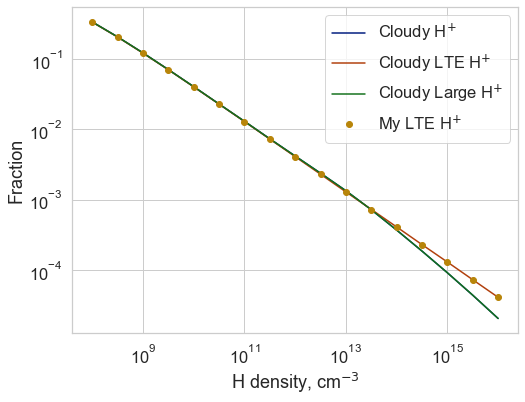

In [62]:
fig, ax = plt.subplots()
#ax.plot(thc['HDEN'], thc['HI/H'], label='Cloudy H$^0$')
ax.plot(thc['HDEN'], thc['HII/H'], label='Cloudy H$^{+}$')
ax.plot(thc['HDEN'], thf['HII/H'], label='Cloudy LTE H$^{+}$')
ax.plot(thc['HDEN'], thl['HII/H'], label='Cloudy Large H$^{+}$')
ax.plot(thc['HDEN'], Hplus_fraction_U(thc['HDEN'], 5000.), 'o', c='y', label='My LTE H$^{+}$')
ax.set(xscale='log', yscale='log', xlabel='H density, cm$^{-3}$', ylabel='Fraction')
leg = ax.legend(frameon=True, framealpha=0.8)
leg.get_frame().set_facecolor('white')
fig.savefig('cloudy/density_grid_hplus.pdf')
fig.savefig('cloudy/density_grid_hplus.png')
None

The green line and yellow dots are indistinguishable. This is a good start - at least we agree about the LTE H ionization.  However, the blue line (Cloudy free-wheeling model) *does* show deviations for $N > 10^{13.5}$.

#### Now the negative hydrogen abundance: H$^-$

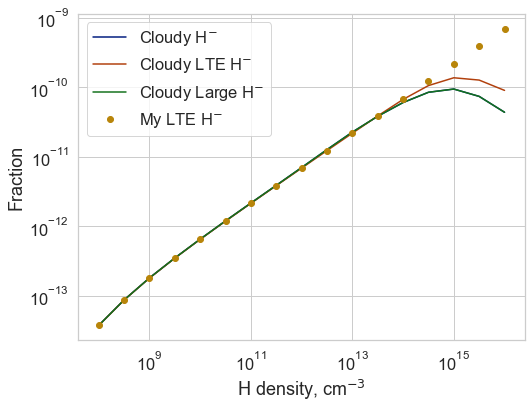

In [63]:
fig, ax = plt.subplots()
ax.plot(thc['HDEN'], thc['H-/H'], label='Cloudy H$^{-}$')
ax.plot(thc['HDEN'], thf['H-/H'], label='Cloudy LTE H$^{-}$')
ax.plot(thc['HDEN'], thl['H-/H'], label='Cloudy Large H$^{-}$')
ax.plot(thc['HDEN'], Hminus_fraction(thc['HDEN'], 5000.), 'o', c='y', label='My LTE H$^{-}$')
ax.set(xscale='log', yscale='log', xlabel='H density, cm$^{-3}$', ylabel='Fraction')
leg = ax.legend(frameon=True, framealpha=0.8)
leg.get_frame().set_facecolor('white')
None

So, again, we see deviations for high densities.  But this time, even the LTE Cloudy model disagrees with my Saha equation. 

Could it be some kind of continuum lowering that is going on?  Since H$^-$ has only one bound level, then the close packing effect will not kick in until the density is so high that pressure ionization occurs. 

#### Level populations

We can't just read the data in with `Table.read` because the lines are of unequal lengths

Define a function to deal with inconsistent row lengths

In [64]:
def pad_row(str_vals, ncols):
    nmissing = ncols - len(str_vals)
    if nmissing > 0:
        # Pad with empty strings if we have too few values
        return str_vals + ['']*nmissing
    elif nmissing < 0:
        # Truncate if we have too many values
        return str_vals[:ncols]
    else:
        # Case of "just right"
        return str_vals

In [65]:
pad_row(['a', 'b'], 4)

['a', 'b', '', '']

In [66]:
pad_row(['a', 'b', 'c', 'd', 'e'], 4)

['a', 'b', 'c', 'd']

In [69]:
from astropy.io import ascii

##
## NOTE: This class can only be defined once per session
##
class NoHeaderVary(ascii.NoHeader):
    """Reader for Cloudy output files with variable length rows
    """
    _format_name = 'vary'
    _description = 'Basic table with variable length rows'
    def inconsistent_handler(self, str_vals, ncols):
        return pad_row(str_vals, ncols)


In [70]:
def get_level_lists(nresolved = 10, ncollapsed = 100):
    levels_n_l = [[f'n({qn},{ql})' for ql in range(qn)] for qn in range(1, nresolved+1)] 
    levels_n_l += [[f'n({qn})'] for qn in range(nresolved+1, ncollapsed+nresolved)]

    flat_levels = []
    for sublevels in levels_n_l:
        flat_levels.extend(sublevels)

    return levels_n_l, flat_levels


levels_n_l, flat_levels = get_level_lists()
levels_n_l_large, flat_levels_large = get_level_lists(40, 60)

flat_levels_large[-100:-50]

['n(39,38)',
 'n(40,0)',
 'n(40,1)',
 'n(40,2)',
 'n(40,3)',
 'n(40,4)',
 'n(40,5)',
 'n(40,6)',
 'n(40,7)',
 'n(40,8)',
 'n(40,9)',
 'n(40,10)',
 'n(40,11)',
 'n(40,12)',
 'n(40,13)',
 'n(40,14)',
 'n(40,15)',
 'n(40,16)',
 'n(40,17)',
 'n(40,18)',
 'n(40,19)',
 'n(40,20)',
 'n(40,21)',
 'n(40,22)',
 'n(40,23)',
 'n(40,24)',
 'n(40,25)',
 'n(40,26)',
 'n(40,27)',
 'n(40,28)',
 'n(40,29)',
 'n(40,30)',
 'n(40,31)',
 'n(40,32)',
 'n(40,33)',
 'n(40,34)',
 'n(40,35)',
 'n(40,36)',
 'n(40,37)',
 'n(40,38)',
 'n(40,39)',
 'n(41)',
 'n(42)',
 'n(43)',
 'n(44)',
 'n(45)',
 'n(46)',
 'n(47)',
 'n(48)',
 'n(49)']

In [71]:
names = ['depth', 'n(H0)', 'n(H+)'] + flat_levels
tpc = Table.read(fn.replace('.hcond', '.hpop'), format='ascii.vary', names=names, guess=False, delimiter='\t')
tpf = Table.read(fn.replace('limit', 'force').replace('.hcond', '.hpop'), format='ascii.vary', names=names, delimiter='\t')

In [72]:
tpc

depth,n(H0),n(H+),"n(1,0)","n(2,0)","n(2,1)","n(3,0)","n(3,1)","n(3,2)","n(4,0)","n(4,1)","n(4,2)","n(4,3)","n(5,0)","n(5,1)","n(5,2)","n(5,3)","n(5,4)","n(6,0)","n(6,1)","n(6,2)","n(6,3)","n(6,4)","n(6,5)","n(7,0)","n(7,1)","n(7,2)","n(7,3)","n(7,4)","n(7,5)","n(7,6)","n(8,0)","n(8,1)","n(8,2)","n(8,3)","n(8,4)","n(8,5)","n(8,6)","n(8,7)","n(9,0)","n(9,1)","n(9,2)","n(9,3)","n(9,4)","n(9,5)","n(9,6)","n(9,7)","n(9,8)","n(10,0)","n(10,1)","n(10,2)","n(10,3)","n(10,4)","n(10,5)","n(10,6)","n(10,7)","n(10,8)","n(10,9)",n(11),n(12),n(13),n(14),n(15),n(16),n(17),n(18),n(19),n(20),n(21),n(22),n(23),n(24),n(25),n(26),n(27),n(28),n(29),n(30),n(31),n(32),n(33),n(34),n(35),n(36),n(37),n(38),n(39),n(40),n(41),n(42),n(43),n(44),n(45),n(46),n(47),n(48),n(49),n(50),n(51),n(52),n(53),n(54),n(55),n(56),n(57),n(58),n(59),n(60),n(61),n(62),n(63),n(64),n(65),n(66),n(67),n(68),n(69),n(70),n(71),n(72),n(73),n(74),n(75),n(76),n(77),n(78),n(79),n(80),n(81),n(82),n(83),n(84),n(85),n(86),n(87),n(88),n(89),n(90),n(91),n(92),n(93),n(94),n(95),n(96),n(97),n(98),n(99),n(100),n(101),n(102),n(103),n(104),n(105),n(106),n(107),n(108),n(109)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.5,66400000.0,33600000.0,66400000.0,0.00353,0.0106,4.42e-05,0.000132,0.000221,9.54e-06,2.85e-05,4.77e-05,6.67e-05,4.69e-06,1.41e-05,2.34e-05,3.28e-05,4.22e-05,3.17e-06,9.49e-06,1.59e-05,2.23e-05,2.87e-05,3.5e-05,2.53e-06,7.62e-06,1.26e-05,1.77e-05,2.27e-05,2.77e-05,3.28e-05,2.14e-06,6.42e-06,1.08e-05,1.51e-05,1.95e-05,2.38e-05,2.82e-05,3.25e-05,1.94e-06,5.8e-06,9.73e-06,1.36e-05,1.76e-05,2.15e-05,2.54e-05,2.93e-05,3.32e-05,1.83e-06,5.48e-06,9.1e-06,1.27e-05,1.63e-05,2e-05,2.36e-05,2.72e-05,3.08e-05,3.45e-05,0.000208,0.000237,0.000269,0.000304,0.000342,0.000382,0.000426,0.000472,0.00052,0.000571,0.000625,0.000682,0.000741,0.000803,0.000868,0.000935,0.001,0.00108,0.00115,0.00123,0.00131,0.00139,0.00148,0.00157,0.00166,0.00175,0.00185,0.00195,0.00205,0.00215,0.00226,0.00237,0.00248,0.0026,0.00271,0.00284,0.00296,0.00308,0.00321,0.00334,0.00348,0.00361,0.00375,0.00389,0.00403,0.00418,0.00433,0.00448,0.00464,0.00479,0.00495,0.00512,0.00528,0.00545,0.00562,0.00579,0.00597,0.00615,0.00633,0.00651,0.0067,0.00688,0.00708,0.00727,0.00747,0.00767,0.00787,0.00807,0.00828,0.00849,0.0087,0.00892,0.00914,0.00936,0.00958,0.0098,0.01,0.0103,0.0105,0.0107,0.011,0.0112,0.0115,0.0117,0.012,0.0122,0.0125,0.0127,0.013,0.0132,0.0135,0.0138,0.014,0.0143,0.0146,0.0149,0.0152,0.0154,0.0157
0.5,251000000.0,65300000.0,251000000.0,0.0133,0.0401,0.000167,0.0005,0.000835,3.6e-05,0.000108,0.00018,0.000252,1.77e-05,5.34e-05,8.86e-05,0.000124,0.000159,1.2e-05,3.59e-05,6.01e-05,8.42e-05,0.000108,0.000132,9.57e-06,2.88e-05,4.77e-05,6.67e-05,8.58e-05,0.000105,0.000124,8.11e-06,2.43e-05,4.07e-05,5.72e-05,7.36e-05,9e-05,0.00010

In [73]:
len(tpc[1])

157

In [74]:
tpf

depth,n(H0),n(H+),"n(1,0)","n(2,0)","n(2,1)","n(3,0)","n(3,1)","n(3,2)","n(4,0)","n(4,1)","n(4,2)","n(4,3)","n(5,0)","n(5,1)","n(5,2)","n(5,3)","n(5,4)","n(6,0)","n(6,1)","n(6,2)","n(6,3)","n(6,4)","n(6,5)","n(7,0)","n(7,1)","n(7,2)","n(7,3)","n(7,4)","n(7,5)","n(7,6)","n(8,0)","n(8,1)","n(8,2)","n(8,3)","n(8,4)","n(8,5)","n(8,6)","n(8,7)","n(9,0)","n(9,1)","n(9,2)","n(9,3)","n(9,4)","n(9,5)","n(9,6)","n(9,7)","n(9,8)","n(10,0)","n(10,1)","n(10,2)","n(10,3)","n(10,4)","n(10,5)","n(10,6)","n(10,7)","n(10,8)","n(10,9)",n(11),n(12),n(13),n(14),n(15),n(16),n(17),n(18),n(19),n(20),n(21),n(22),n(23),n(24),n(25),n(26),n(27),n(28),n(29),n(30),n(31),n(32),n(33),n(34),n(35),n(36),n(37),n(38),n(39),n(40),n(41),n(42),n(43),n(44),n(45),n(46),n(47),n(48),n(49),n(50),n(51),n(52),n(53),n(54),n(55),n(56),n(57),n(58),n(59),n(60),n(61),n(62),n(63),n(64),n(65),n(66),n(67),n(68),n(69),n(70),n(71),n(72),n(73),n(74),n(75),n(76),n(77),n(78),n(79),n(80),n(81),n(82),n(83),n(84),n(85),n(86),n(87),n(88),n(89),n(90),n(91),n(92),n(93),n(94),n(95),n(96),n(97),n(98),n(99),n(100),n(101),n(102),n(103),n(104),n(105),n(106),n(107),n(108),n(109)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.5,66600000.0,33400000.0,66600000.0,0.00349,0.0105,4.36e-05,0.000131,0.000218,9.4e-06,2.82e-05,4.7e-05,6.58e-05,4.62e-06,1.39e-05,2.31e-05,3.24e-05,4.16e-05,3.14e-06,9.43e-06,1.57e-05,2.2e-05,2.83e-05,3.46e-05,2.49e-06,7.47e-06,1.25e-05,1.74e-05,2.24e-05,2.74e-05,3.24e-05,2.14e-06,6.43e-06,1.07e-05,1.5e-05,1.93e-05,2.36e-05,2.78e-05,3.21e-05,1.93e-06,5.79e-06,9.66e-06,1.35e-05,1.74e-05,2.12e-05,2.51e-05,2.9e-05,3.28e-05,1.79e-06,5.38e-06,8.97e-06,1.26e-05,1.61e-05,1.97e-05,2.33e-05,2.69e-05,3.05e-05,3.41e-05,0.000205,0.000235,0.000266,0.000301,0.000339,0.000379,0.000422,0.000467,0.000515,0.000566,0.00062,0.000676,0.000735,0.000796,0.00086,0.000927,0.000996,0.00107,0.00114,0.00122,0.0013,0.00138,0.00147,0.00155,0.00164,0.00174,0.00183,0.00193,0.00203,0.00213,0.00224,0.00235,0.00246,0.00257,0.00269,0.00281,0.00293,0.00306,0.00318,0.00331,0.00344,0.00358,0.00372,0.00386,0.004,0.00414,0.00429,0.00444,0.0046,0.00475,0.00491,0.00507,0.00523,0.0054,0.00557,0.00574,0.00591,0.00609,0.00627,0.00645,0.00664,0.00682,0.00701,0.0072,0.0074,0.0076,0.0078,0.008,0.00821,0.00841,0.00862,0.00884,0.00905,0.00927,0.00949,0.00972,0.00994,0.0102,0.0104,0.0106,0.0109,0.0111,0.0114,0.0116,0.0118,0.0121,0.0123,0.0126,0.0129,0.0131,0.0134,0.0137,0.0139,0.0142,0.0145,0.0147,0.015,0.0153,0.0156
0.5,251000000.0,65000000.0,251000000.0,0.0132,0.0396,0.000165,0.000494,0.000823,3.55e-05,0.000106,0.000177,0.000248,1.74e-05,5.23e-05,8.72e-05,0.000122,0.000157,1.19e-05,3.56e-05,5.93e-05,8.31e-05,0.000107,0.000131,9.4e-06,2.82e-05,4.7e-05,6.58e-05,8.46e-05,0.000103,0.000122,8.09e-06,2.43e-05,4.04e-05,5.66e-05,7.28e-05,8.89e-05

In [75]:
names = ['depth', 'n(H0)', 'n(H+)'] + flat_levels_large
tpl = Table.read(fn.replace('hminus', 'hminus_large').replace('.hcond', '.hpop'), format='ascii.vary', names=names, guess=False, delimiter='\t')

In [76]:
tpl

depth,n(H0),n(H+),"n(1,0)","n(2,0)","n(2,1)","n(3,0)","n(3,1)","n(3,2)","n(4,0)","n(4,1)","n(4,2)","n(4,3)","n(5,0)","n(5,1)","n(5,2)","n(5,3)","n(5,4)","n(6,0)","n(6,1)","n(6,2)","n(6,3)","n(6,4)","n(6,5)","n(7,0)","n(7,1)","n(7,2)","n(7,3)","n(7,4)","n(7,5)","n(7,6)","n(8,0)","n(8,1)","n(8,2)","n(8,3)","n(8,4)","n(8,5)","n(8,6)","n(8,7)","n(9,0)","n(9,1)","n(9,2)","n(9,3)","n(9,4)","n(9,5)","n(9,6)","n(9,7)","n(9,8)","n(10,0)","n(10,1)","n(10,2)","n(10,3)","n(10,4)","n(10,5)","n(10,6)","n(10,7)","n(10,8)","n(10,9)","n(11,0)","n(11,1)","n(11,2)","n(11,3)","n(11,4)","n(11,5)","n(11,6)","n(11,7)","n(11,8)","n(11,9)","n(11,10)","n(12,0)","n(12,1)","n(12,2)","n(12,3)","n(12,4)","n(12,5)","n(12,6)","n(12,7)","n(12,8)","n(12,9)","n(12,10)","n(12,11)","n(13,0)","n(13,1)","n(13,2)","n(13,3)","n(13,4)","n(13,5)","n(13,6)","n(13,7)","n(13,8)","n(13,9)","n(13,10)","n(13,11)","n(13,12)","n(14,0)","n(14,1)","n(14,2)","n(14,3)","n(14,4)","n(14,5)","n(14,6)","n(14,7)","n(14,8)","n(14,9)","n(14,10)","n(14,11)","n(14,12)","n(14,13)","n(15,0)","n(15,1)","n(15,2)","n(15,3)","n(15,4)","n(15,5)","n(15,6)","n(15,7)","n(15,8)","n(15,9)","n(15,10)","n(15,11)","n(15,12)","n(15,13)","n(15,14)","n(16,0)","n(16,1)","n(16,2)","n(16,3)","n(16,4)","n(16,5)","n(16,6)","n(16,7)","n(16,8)","n(16,9)","n(16,10)","n(16,11)","n(16,12)","n(16,13)","n(16,14)","n(16,15)","n(17,0)","n(17,1)","n(17,2)","n(17,3)","n(17,4)","n(17,5)","n(17,6)","n(17,7)","n(17,8)","n(17,9)","n(17,10)","n(17,11)","n(17,12)","n(17,13)","n(17,14)","n(17,15)","n(17,16)","n(18,0)","n(18,1)","n(18,2)","n(18,3)","n(18,4)","n(18,5)","n(18,6)","n(18,7)","n(18,8)","n(18,9)","n(18,10)","n(18,11)","n(18,12)","n(18,13)","n(18,14)","n(18,15)","n(18,16)","n(18,17)","n(19,0)","n(19,1)","n(19,2)","n(19,3)","n(19,4)","n(19,5)","n(19,6)","n(19,7)","n(19,8)","n(19,9)","n(19,10)","n(19,11)","n(19,12)","n(19,13)","n(19,14)","n(19,15)","n(19,16)","n(19,17)","n(19,18)","n(20,0)","n(20,1)","n(20,2)","n(20,3)","n(20,4)","n(20,5)","n(20,6)","n(20,7)","n(20,8)","n(20,9)","n(20,10)","n(20,11)","n(20,12)","n(20,13)","n(20,14)","n(20,15)","n(20,16)","n(20,17)","n(20,18)","n(20,19)","n(21,0)","n(21,1)","n(21,2)","n(21,3)","n(21,4)","n(21,5)","n(21,6)","n(21,7)","n(21,8)","n(21,9)","n(21,10)","n(21,11)","n(21,12)","n(21,13)","n(21,14)","n(21,15)","n(21,16)","n(21,17)","n(21,18)","n(21,19)","n(21,20)","n(22,0)","n(22,1)","n(22,2)","n(22,3)","n(22,4)","n(22,5)","n(22,6)","n(22,7)","n(22,8)","n(22,9)","n(22,10)","n(22,11)","n(22,12)","n(22,13)","n(22,14)","n(22,15)","n(22,16)","n(22,17)","n(22,18)","n(22,19)","n(22,20)","n(22,21)","n(23,0)","n(23,1)","n(23,2)","n(23,3)","n(23,4)","n(23,5)","n(23,6)","n(23,7)","n(23,8)","n(23,9)","n(23,10)","n(23,11)","n(23,12)","n(23,13)","n(23,14)","n(23,15)","n(23,16)","n(23,17)","n(23,18)","n(23,19)","n(23,20)","n(23,21)","n(23,22)","n(24,0)","n(24,1)","n(24,2)","n(24,3)","n(24,4)","n(24,5)","n(24,6)","n(24,7)","n(24,8)","n(24,9)","n(24,10)","n(24,11)","n(24,12)","n(24,13)","n(24,14)","n(24,15)","n(24,16)","n(24,17)","n(24,18)","n(24,19)","n(24,20)","n(24,21)","n(24,22)","n(24,23)","n(25,0)","n(25,1)","n(25,2)","n(25,3)","n(25,4)","n(25,5)","n(25,6)","n(25,7)","n(25,8)","n(25,9)","n(25,10)","n(25,11)","n(25,12)","n(25,13)","n(25,14)","n(25,15)","n(25,16)","n(25,17)","n(25,18)","n(25,19)","n(25,20)","n(25,21)","n(25,22)","n(25,23)","n(25,24)","n(26,0)","n(26,1)","n(26,2)","n(26,3)","n(26,4)","n(26,5)","n(26,6)","n(26,7)","n(26,8)","n(26,9)","n(26,10)","n(26,11)","n(26,12)","n(26,13)","n(26,14)","n(26,15)","n(26,16)","n(26,17)","n(26,18)","n(26,19)","n(26,20)","n(26,21)","n(26,22)","n(26,23)","n(26,24)","n(26,25)","n(27,0)","n(27,1)","n(27,2)","n(27,3)","n(27,4)","n(27,5)","n(27,6)","n(27,7)","n(27,8)","n(27,9)","n(27,10)","n(27,11)","n(27,12)","n(27,13)","n(27,14)","n(27,15)","n(27,16)","n(27,17)","n(27,18)","n(27,19)","n(27,20)","n(27,21)","n(27,22)","n(27,23)","n(27,24)","n(27,25)","n(27,26)","n(28,0)","n(28,1)","n(28,2)","n(28,3)","n(28,4)","n(28,5)","n(28,6)","n(28,7)","n(28,8)","n(2

In [77]:
len(tpl[1])

882

Sum over all the $l$ states to get the population fractions for each $n$.

In [78]:
def make_table_pop_n(tab_pop_n_l, levels_n_l):
    # Start with one column of the total H0
    tnfracs = tab_pop_n_l[['n(H0)']]
    # Loop over all the n-levels
    for i, sublevels in enumerate(levels_n_l):
        qn = i + 1  # quantum number n
        # Add a column with total fraction for this n by summing the individual l populations
        tnfracs[f'n({qn})'] = np.sum([tab_pop_n_l[s] for s in sublevels], axis=0)/tab_pop_n_l['n(H0)']
    return tnfracs

tpf_n = make_table_pop_n(tpf, levels_n_l)
tpc_n = make_table_pop_n(tpc, levels_n_l)
tpl_n = make_table_pop_n(tpl, levels_n_l_large)

[682 547 444 363 298 245 202 166 137 113  93  77  63  52  43  35  29]


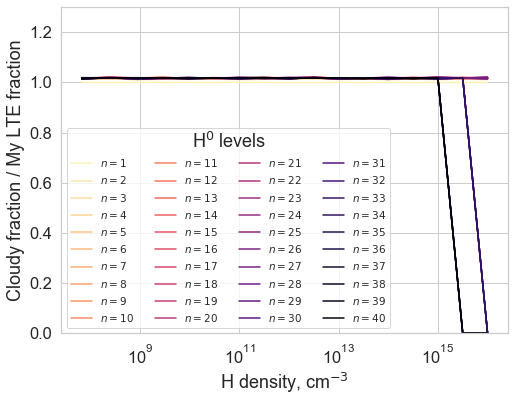

In [79]:
fig, ax = plt.subplots()
T = 5000.0
qn_maxplot = 40
colors = sns.color_palette('magma_r', n_colors=qn_maxplot)
nmax = nmax_pressure_ionization(tpf_n['n(H0)'])
print(nmax.data.astype(int))
U = H0_partition_function(T, nmax=nmax)
for i, c in list(enumerate(colors)):
    qn = i + 1
    myfracs = H0_level_population(qn, T, U=U)
    ax.plot(tpf_n['n(H0)'], tpf_n[f'n({qn})'] / myfracs, color=c, label=f'$n = {qn}$')
ax.set(xscale='log', yscale='linear', xlabel='H density, cm$^{-3}$', 
       ylabel='Cloudy fraction / My LTE fraction', 
       ylim=[0.0, 1.3])
ax.legend(ncol=4, fontsize='xx-small', loc='lower left', title='H$^0$ levels')
None

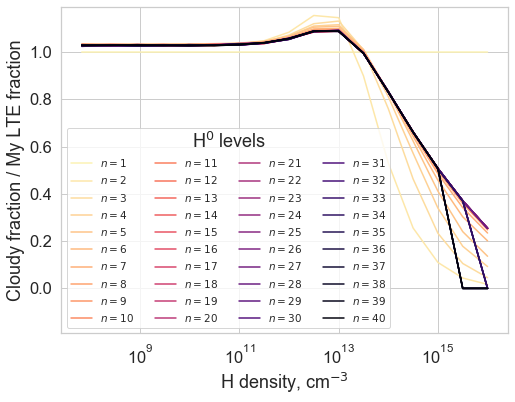

In [80]:
fig, ax = plt.subplots()
T = 5000.0
qn_maxplot = 40
colors = sns.color_palette('magma_r', n_colors=qn_maxplot)
nmax = nmax_pressure_ionization(tpc_n['n(H0)'])
#print(nmax.data.astype(int))
#print(U - 2)
U = H0_partition_function(T, nmax=nmax)
for i, c in list(enumerate(colors)):
    qn = i + 1
    myfracs = H0_level_population(qn, T, U=U)
    ax.plot(tpc_n['n(H0)'], tpc_n[f'n({qn})'] / myfracs, color=c, label=f'$n = {qn}$')
ax.set(xscale='log', yscale='linear', xlabel='H density, cm$^{-3}$', 
       ylabel='Cloudy fraction / My LTE fraction', 
       ylim=[-0.19, 1.19])
leg = ax.legend(ncol=4, fontsize='xx-small', loc='lower left', title='H$^0$ levels', frameon=True, framealpha=0.8)
leg.get_frame().set_facecolor('white')
None

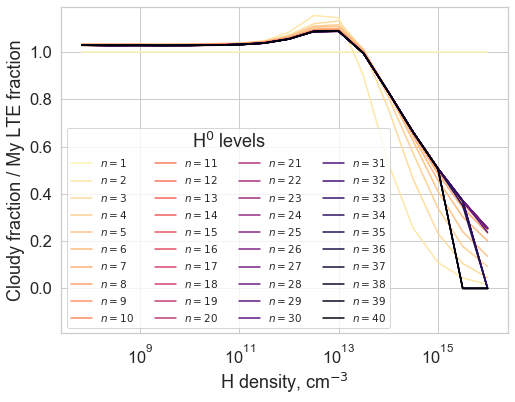

In [81]:
fig, ax = plt.subplots()
T = 5000.0
qn_maxplot = 40
colors = sns.color_palette('magma_r', n_colors=qn_maxplot)
nmax = nmax_pressure_ionization(tpl_n['n(H0)'])
#print(nmax.data.astype(int))
#print(U - 2)
U = H0_partition_function(T, nmax=nmax)
for i, c in list(enumerate(colors)):
    qn = i + 1
    myfracs = H0_level_population(qn, T, U=U)
    ax.plot(tpl_n['n(H0)'], tpl_n[f'n({qn})'] / myfracs, color=c, label=f'$n = {qn}$')
ax.set(xscale='log', yscale='linear', xlabel='H density, cm$^{-3}$', 
       ylabel='Cloudy fraction / My LTE fraction', 
       ylim=[-0.19, 1.19])
leg = ax.legend(ncol=4, fontsize='xx-small', loc='lower left', title='H$^0$ levels', frameon=True, framealpha=0.8)
leg.get_frame().set_facecolor('white')
None

Something simpler would just be to sum all the excited levels.

In [82]:
frac_tab = Table({'n(H0)': tpc_n['n(H0)'].data, 
                  'n*/n': np.sum(tpc_n.columns.values()[2:], axis=0), 
                  'n*/n LTE': np.sum(tpf_n.columns.values()[2:], axis=0), 
                  'n*/n large': np.sum(tpl_n.columns.values()[2:], axis=0)})

In [83]:
#np.sum([c.data for c in tpl_n.columns.values()[2:]], axis=0)
np.sum(tpl_n.columns.values()[2:], axis=0)
#[c for c in tpl_n.columns.values() if '1' in c.name][:4]

array([6.81105437e-09, 6.80528335e-09, 6.80905353e-09, 6.80490850e-09,
       6.80918052e-09, 6.81488922e-09, 6.82831094e-09, 6.87198904e-09,
       6.99341064e-09, 7.21050467e-09, 5.67692142e-09, 2.99786509e-09,
       1.39159590e-09, 6.24857722e-10, 2.70255990e-10, 1.23516899e-10,
       4.96357100e-11])

In [84]:
frac_tab

n(H0),n*/n,n*/n LTE,n*/n large
float64,float64,float64,float64
66400000.0,8.989428915662653e-09,8.880955555555554e-09,6.8110543674698805e-09
251000000.0,8.983811553784862e-09,8.895611354581676e-09,6.805283346613546e-09
878000000.0,8.988342938496581e-09,8.879415017064845e-09,6.809053530751706e-09
2940000000.0,8.984214183673466e-09,8.884748673469385e-09,6.804908503401361e-09
9600000000.0,8.987310000000003e-09,8.88516177083333e-09,6.809180520833334e-09
30900000000.0,8.997701067961165e-09,8.885155469255665e-09,6.81488922330097e-09
98700000000.0,9.017586828774062e-09,8.885775177304964e-09,6.828310942249239e-09
314000000000.0,9.074075350318472e-09,8.883650859872608e-09,6.871989044585987e-09
996000000000.0,9.230866666666665e-09,8.885452309236947e-09,6.99341064257028e-09


And we do the same from my own functions:

In [85]:
@np.vectorize
def H0_total_excited_population(Hden, T):
  nmax = nmax_pressure_ionization(Hden)
  U = H0_partition_function(T, nmax=nmax)
  pop = np.zeros_like(T)
  for n in range(2, int(nmax)+1):
    pop += H0_level_population(n, T, U=U)
  return pop

In [86]:
H0_total_excited_population(1e12, 5000.)

array(1.70419276e-08)

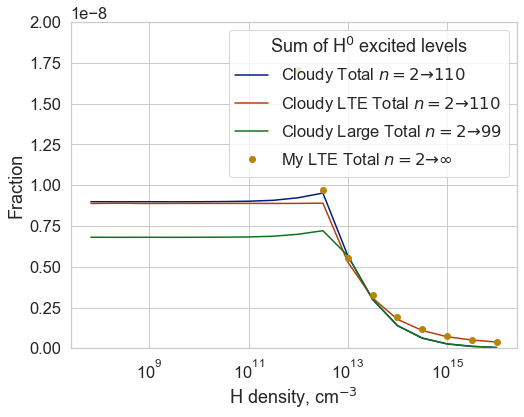

In [87]:
fig, ax = plt.subplots()
T = 5000.0
ax.plot(frac_tab['n(H0)'], frac_tab['n*/n'], label=r'Cloudy Total $n=2 \to 110$')
ax.plot(frac_tab['n(H0)'], frac_tab['n*/n LTE'], label=r'Cloudy LTE Total $n=2 \to 110$')
ax.plot(frac_tab['n(H0)'], frac_tab['n*/n large'], label=r'Cloudy Large Total $n=2 \to 99$')
ax.plot(frac_tab['n(H0)'], H0_total_excited_population(frac_tab['n(H0)'], T), 'o', c='y', label=r'My LTE Total $n=2 \to \infty$')
ax.set(xscale='log', yscale='linear', ylim=[0.0, 2.e-8], xlabel='H density, cm$^{-3}$', ylabel=r'Fraction')
leg = ax.legend(title='Sum of H$^0$ excited levels', frameon=True, framealpha=0.8)
leg.get_frame().set_facecolor('white')
None

So the disagreement of Cloudy with my values for low density is to be expected, since Cloudy only uses 110 levels, which is less than $n_\mathrm{max}$ for $N < 10^{13}\ \mathrm{cm}^{-3}$.

For higher densities, the agreement is very good with the Cloudy forced LTE model, but the non-forced model falls consistently below. 